# ADS-B Trajectories: Load → Resample → Autoencode → Compare

This notebook is organized into small, restartable cells. Each cell starts with a short explanation and can be re-run independently:

- Cell 2: Configuration and imports.
- Cell 3: Load the parquet dataset and print a compact summary.
- Cell 4: Resample all trajectories to 100 points and save to CSV (idempotent).
- Cell 5: Define the autoencoder class (shared by training/inference).
- Cell 6: Train autoencoder, save scaler and model (skips if already saved unless forced).
- Cell 7: Reconstruct and compare original vs autoencoded trajectories side-by-side and save per-trajectory MSEs.

Tip: You can change settings (like file paths or limits) in the Configuration cell and re-run just what you need.

In [1]:
# Configuration and imports
# - Edit FILENAME if needed
# - This cell only sets up environment and config; re-run anytime safely.

import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File paths
FILENAME = 'traffic_noga_tilFAF_train.parquet'
RESAMPLED_CSV = 'traffic_noga_resampled.csv'
SCALER_PATH = 'trajectory_scaler.joblib'
MODEL_PATH = 'trajectory_autoencoder.pth'

# Resampling
TARGET_POINTS = 100

print('Configuration loaded:')
print(f'  Parquet: {FILENAME}')
print(f'  Resampled CSV: {RESAMPLED_CSV}')
print(f'  Scaler: {SCALER_PATH}')
print(f'  Model: {MODEL_PATH}')
print(f'  Target points per trajectory: {TARGET_POINTS}')

Configuration loaded:
  Parquet: traffic_noga_tilFAF_train.parquet
  Resampled CSV: traffic_noga_resampled.csv
  Scaler: trajectory_scaler.joblib
  Model: trajectory_autoencoder.pth
  Target points per trajectory: 100


Loaded: traffic_noga_tilFAF_train.parquet
Shape: (2800000, 23)
Columns: ['timestamp', 'altitude', 'callsign', 'geoaltitude', 'groundspeed', 'icao24', 'lastseen', 'latitude', 'longitude', 'onground', 'origin', 'track', 'vertical_rate', 'distance', 'flight_id', 'runway', 'initial_bearing', 'initial_flow', 'simple', 'track_unwrapped', 'timedelta', 'x', 'y']

Summary:
  Total rows: 2,800,000
  Unique flights: 14,000
  Date range: 2019-10-01 04:57:13+00:00 → 2019-11-30 18:57:37+00:00
  Lat range:  46.8019 → 48.1302
  Lon range:  7.5702 → 9.5276

Grouped into 14000 trajectories

Original Data Statistics:


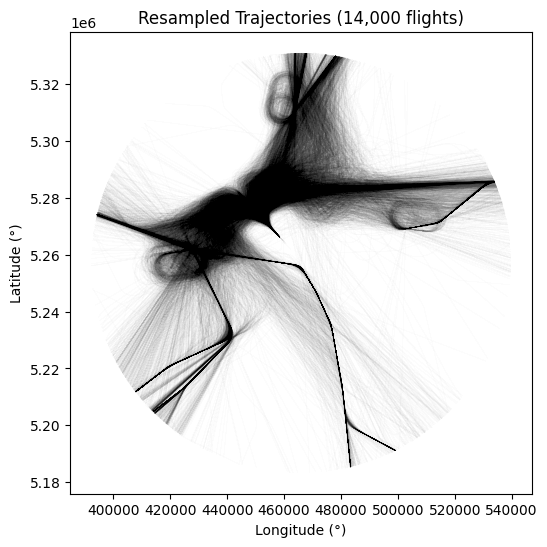

In [2]:
# Load parquet dataset and show a compact summary
# - Reads the parquet file defined in FILENAME
# - Produces a concise summary of rows, columns, and basic ranges

assert os.path.exists(FILENAME), f"Parquet file not found: {FILENAME}"
df = pd.read_parquet(FILENAME)
print(f"Loaded: {FILENAME}")
print(f"Shape: {df.shape}")
print("Columns:", df.columns.tolist())

# Quick summary
print("\nSummary:")
print(f"  Total rows: {len(df):,}")
print(f"  Unique flights: {df['flight_id'].nunique():,}")
if 'timestamp' in df.columns:
    print(f"  Date range: {df['timestamp'].min()} → {df['timestamp'].max()}")
if 'latitude' in df.columns and 'longitude' in df.columns:
    print(f"  Lat range:  {df['latitude'].min():.4f} → {df['latitude'].max():.4f}")
    print(f"  Lon range:  {df['longitude'].min():.4f} → {df['longitude'].max():.4f}")

# Group for later steps
trajectories = df.groupby('flight_id')
print(f"\nGrouped into {len(trajectories)} trajectories")


#show the original data stats
print("\nOriginal Data Statistics:")
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection

# group once (no repeated boolean filters)
groups = trajectories

# build list of polylines as Nx2 numpy arrays
lines = [np.column_stack((g['x'].to_numpy(), g['y'].to_numpy()))
         for _, g in groups if len(g) > 1]

fig, ax = plt.subplots(figsize=(10, 6))
lc = LineCollection(
    lines,
    linewidths=0.1,
    alpha=0.01,       # reduce if still slow; try removing alpha for speed
    antialiased=False,
    color = 'black'
)
ax.add_collection(lc)
ax.autoscale()        # fits the data bounds
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'Resampled Trajectories ({len(lines):,} flights)')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.grid(False)        # grid costs; turn off for speed
plt.show()


In [3]:
# Resample all flights to 100 points and apply global normalization preserving X:Y aspect ratio
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

TARGET_POINTS = 100
resampled_rows = []
flight_ids = df['flight_id'].unique()

# First pass: resample all trajectories
all_resampled_x = []
all_resampled_y = []

for fid in flight_ids:
    sub = df[df['flight_id'] == fid].sort_values('timestamp')
    t_original = np.linspace(0, 1, len(sub))
    t_target = np.linspace(0, 1, TARGET_POINTS)
    fx = interp1d(t_original, sub['x'], kind='linear', fill_value='extrapolate')
    fy = interp1d(t_original, sub['y'], kind='linear', fill_value='extrapolate')
    x_resampled = fx(t_target)
    y_resampled = fy(t_target)
    all_resampled_x.append(x_resampled)
    all_resampled_y.append(y_resampled)

# Stack all trajectories to compute global statistics
all_x = np.concatenate(all_resampled_x)
all_y = np.concatenate(all_resampled_y)

# Global min/max
x_min, x_max = all_x.min(), all_x.max()
y_min, y_max = all_y.min(), all_y.max()

# Compute ranges
x_range = x_max - x_min
y_range = y_max - y_min

# Use the maximum range to preserve aspect ratio
max_range = max(x_range, y_range)

print(f"Global X range: [{x_min:.6f}, {x_max:.6f}] -> {x_range:.6f}")
print(f"Global Y range: [{y_min:.6f}, {y_max:.6f}] -> {y_range:.6f}")
print(f"Using max_range: {max_range:.6f} for scaling")

# Second pass: normalize with aspect ratio preservation
for i, fid in enumerate(flight_ids):
    x_resampled = all_resampled_x[i]
    y_resampled = all_resampled_y[i]
    
    # Normalize to [0, 1] while preserving aspect ratio
    # Center the data and scale by the max_range
    x_centered = (x_resampled - x_min)
    y_centered = (y_resampled - y_min)
    
    x_norm = x_centered / max_range
    y_norm = y_centered / max_range
    
    resampled = pd.DataFrame({
        'flight_id': fid,
        'x': x_norm,
        'y': y_norm
    })
    resampled_rows.append(resampled)

resampled_df = pd.concat(resampled_rows, ignore_index=True)
resampled_df.to_csv('traffic_noga_resampled.csv', index=False)

print(f'\nResampled {len(flight_ids)} flights to {TARGET_POINTS} points with global normalization')
print(f'Aspect ratio preserved using max_range scaling')
print(f'Saved to traffic_noga_resampled.csv')
print(f'\nNormalized X range: [{resampled_df["x"].min():.6f}, {resampled_df["x"].max():.6f}]')
print(f'Normalized Y range: [{resampled_df["y"].min():.6f}, {resampled_df["y"].max():.6f}]')

Global X range: [392208.815645, 539761.998355] -> 147553.182710
Global Y range: [5183352.528643, 5330953.812960] -> 147601.284318
Using max_range: 147601.284318 for scaling

Resampled 14000 flights to 100 points with global normalization
Aspect ratio preserved using max_range scaling
Saved to traffic_noga_resampled.csv

Normalized X range: [0.000000, 0.999674]
Normalized Y range: [0.000000, 1.000000]


In [4]:
# Load resampled data (in degrees)
import pandas as pd
resampled_df = pd.read_csv('traffic_noga_resampled.csv')
print(resampled_df.head())

#give the whole stats of the data, min, max, mean, std for x and y
print("\nResampled Data Statistics:")
print(f"  x: min={resampled_df['x'].min():.4f}, max={resampled_df['x'].max():.4f}, mean={resampled_df['x'].mean():.4f}, std={resampled_df['x'].std():.4f}")
print(f"  y: min={resampled_df['y'].min():.4f}, max={resampled_df['y'].max():.4f}, mean={resampled_df['y'].mean():.4f}, std={resampled_df['y'].std():.4f}")


   flight_id         x         y
0  2FPLF_000  0.617741  0.014482
1  2FPLF_000  0.616402  0.026583
2  2FPLF_000  0.615118  0.038745
3  2FPLF_000  0.613941  0.051184
4  2FPLF_000  0.612729  0.063592

Resampled Data Statistics:
  x: min=0.0000, max=0.9997, mean=0.4336, std=0.1768
  y: min=0.0000, max=1.0000, mean=0.6220, std=0.1537


In [6]:
# Define the Autoencoder class (shared)
# - Encoder: 200 -> 128 -> 128 -> 64 -> 32
# - Decoder: 32 -> 64 -> 128 -> 128 -> 200

import torch
import torch.nn as nn

class TrajectoryAutoencoder(nn.Module):
    def __init__(self, input_dim=200, encoding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 64),  nn.ReLU(),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),  nn.ReLU(),
            nn.Linear(64, 128),  nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    def encode(self, x):
        return self.encoder(x)

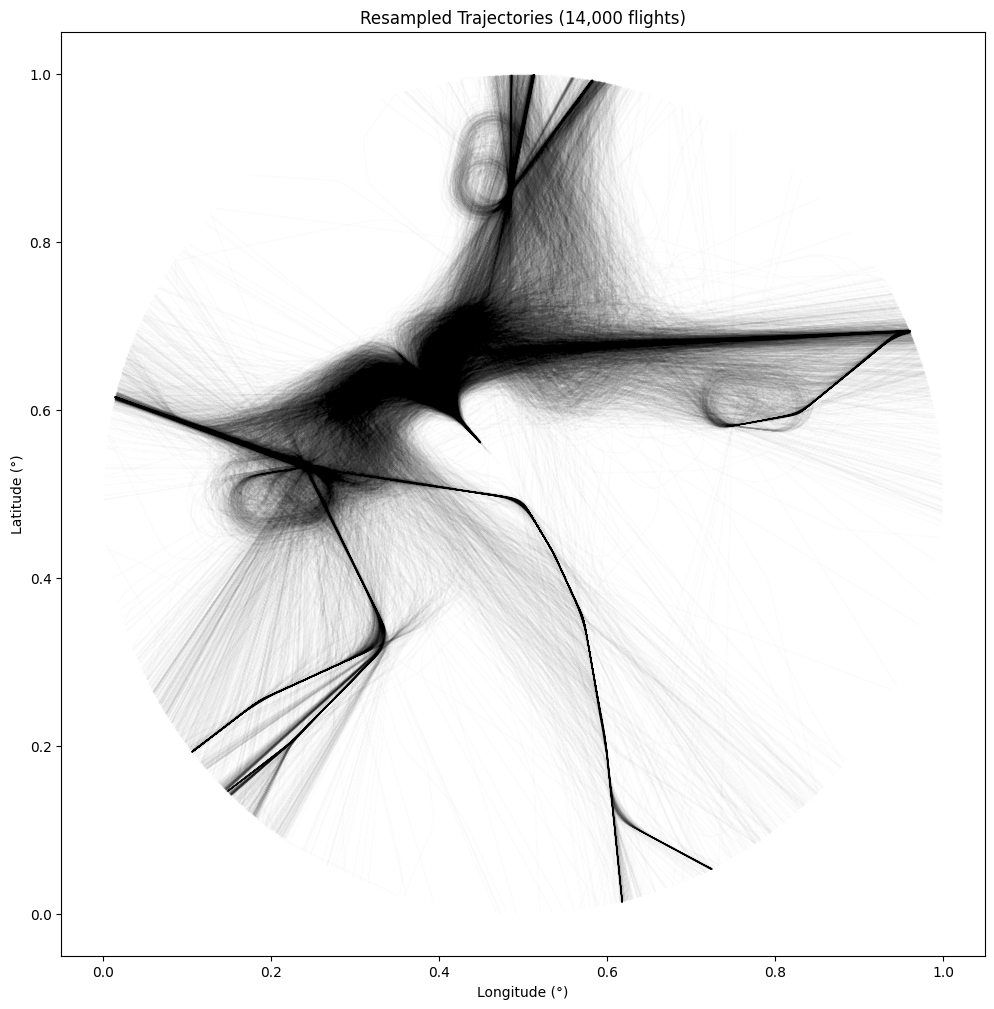

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection

# group once (no repeated boolean filters)
groups = resampled_df.groupby('flight_id', sort=False)

# build list of polylines as Nx2 numpy arrays
lines = [np.column_stack((g['x'].to_numpy(), g['y'].to_numpy()))
         for _, g in groups if len(g) > 1]

fig, ax = plt.subplots(figsize=(12, 12))
lc = LineCollection(
    lines,
    linewidths=0.4,
    alpha=0.01,       # reduce if still slow; try removing alpha for speed
    antialiased=False,
       colors='black',  # single color is faster than colormap
)
ax.add_collection(lc)
ax.autoscale()        # fits the data bounds
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'Resampled Trajectories ({len(lines):,} flights)')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.grid(False)        # grid costs; turn off for speed
plt.show()


In [ ]:
# Prepare data for autoencoder (in degrees)
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

TARGET_POINTS = 100
# Flatten x/y for each flight into a single vector (200 features)
flight_ids = resampled_df['flight_id'].unique()
X = []
for fid in flight_ids:
    sub = resampled_df[resampled_df['flight_id'] == fid]
    X.append(np.concatenate([sub['x'].values, sub['y'].values]))
X = np.stack(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'trajectory_scaler.joblib')
print('Prepared and scaled data for autoencoder (degrees). Saved scaler to trajectory_scaler.joblib.')

In [ ]:
# Train autoencoder on resampled data (degrees)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class TrajectoryAutoencoder(nn.Module):
    def __init__(self, input_dim=200, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
           nn.Linear(128, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Prepare data
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model
model = TrajectoryAutoencoder(input_dim=200, latent_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
EPOCHS = 200
for epoch in range(EPOCHS):
    losses = []
    for (batch,) in loader:
        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {np.mean(losses):.4f}')

# Save model
torch.save(model.state_dict(), 'trajectory_autoencoder.pth')
print('Trained autoencoder and saved to trajectory_autoencoder.pth')

Epoch 10/200, Loss: 0.0103
Epoch 20/200, Loss: 0.0075
Epoch 20/200, Loss: 0.0075
Epoch 30/200, Loss: 0.0059
Epoch 30/200, Loss: 0.0059
Epoch 40/200, Loss: 0.0055
Epoch 40/200, Loss: 0.0055
Epoch 50/200, Loss: 0.0057
Epoch 50/200, Loss: 0.0057
Epoch 60/200, Loss: 0.0036
Epoch 60/200, Loss: 0.0036
Epoch 70/200, Loss: 0.0033
Epoch 70/200, Loss: 0.0033
Epoch 80/200, Loss: 0.0041
Epoch 80/200, Loss: 0.0041
Epoch 90/200, Loss: 0.0034
Epoch 90/200, Loss: 0.0034
Epoch 100/200, Loss: 0.0033
Epoch 100/200, Loss: 0.0033
Epoch 110/200, Loss: 0.0029
Epoch 110/200, Loss: 0.0029
Epoch 120/200, Loss: 0.0029
Epoch 120/200, Loss: 0.0029
Epoch 130/200, Loss: 0.0029
Epoch 130/200, Loss: 0.0029
Epoch 140/200, Loss: 0.0026
Epoch 140/200, Loss: 0.0026
Epoch 150/200, Loss: 0.0024
Epoch 150/200, Loss: 0.0024
Epoch 160/200, Loss: 0.0027
Epoch 160/200, Loss: 0.0027
Epoch 170/200, Loss: 0.0027
Epoch 170/200, Loss: 0.0027
Epoch 180/200, Loss: 0.0023
Epoch 180/200, Loss: 0.0023
Epoch 190/200, Loss: 0.0025
Epoch 190

[1/5] Loading CSV…
   Rows: 1,400,000 | Flights: 14,000
[2/5] Building feature matrix…
   Rows: 1,400,000 | Flights: 14,000
[2/5] Building feature matrix…
   X shape: (14000, 200) (flights x 200 features)
[3/5] AE reconstruction + MSE (batched)…
   MSE stats — mean: 0.000034, median: 0.000016
[4/5] Selecting best/worst…
   Saved: top_best_100_reconstructed_flights.csv, top_worst_100_reconstructed_flights.csv
[5/5] Plotting overlays…
   X shape: (14000, 200) (flights x 200 features)
[3/5] AE reconstruction + MSE (batched)…
   MSE stats — mean: 0.000034, median: 0.000016
[4/5] Selecting best/worst…
   Saved: top_best_100_reconstructed_flights.csv, top_worst_100_reconstructed_flights.csv
[5/5] Plotting overlays…


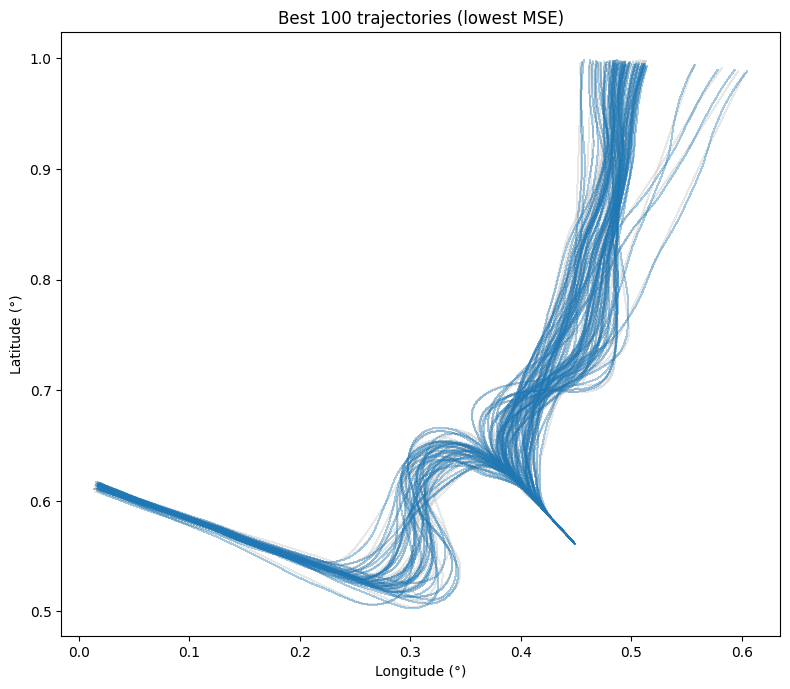

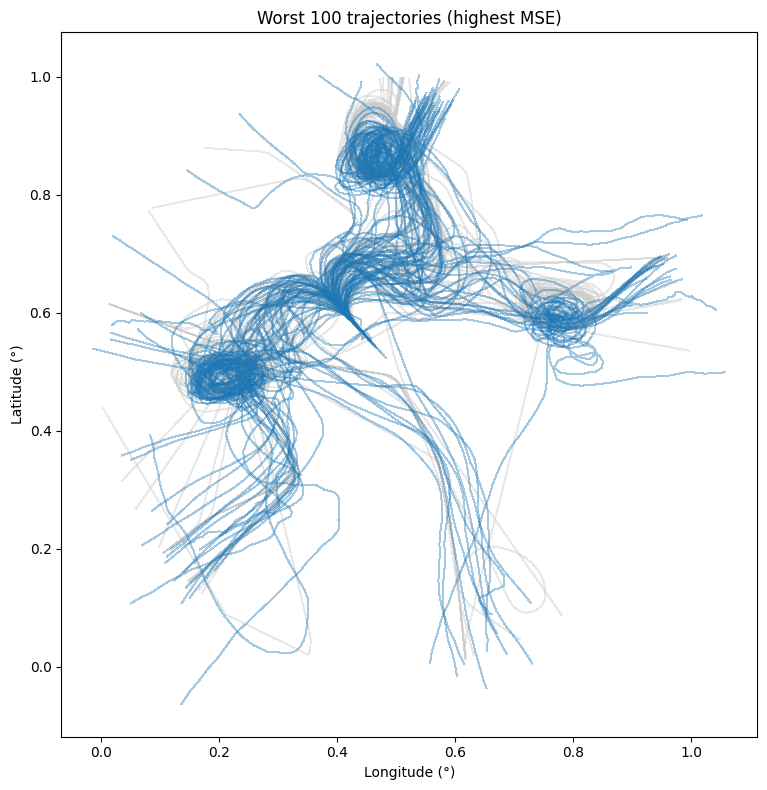

Done. Best mean MSE: 0.000004 | Worst mean MSE: 0.000616


In [ ]:
# ==== FAST: robust load -> feature matrix -> AE recon -> top/bottom -> plots ====
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import torch
import torch.nn as nn
import joblib

# -------------------- CONFIG --------------------
RESAMPLED_CSV = 'traffic_noga_resampled.csv'   # input CSV (x,y in degrees, 100 samples/flight)
SCALER_PATH   = 'trajectory_scaler.joblib'     # StandardScaler (fit on 2*T features)
MODEL_PATH    = 'trajectory_autoencoder.pth'   # torch AE state_dict
T             = 100                             # samples per flight
N             = 100                             # how many best/worst to export/plot
LATLON_BOUNDS_CHECK = False                     # set True to warn about out-of-range coords

# Optional: inference batch size
BATCH_GPU = 8192
BATCH_CPU = 2048

# Optional: enable fp16 on GPU for extra speed (only if scaler/model tolerate it)
USE_FP16 = False

# -------------------- MODEL DEF --------------------
class TrajectoryAutoencoder(nn.Module):
    def __init__(self, input_dim=200, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
           nn.Linear(128, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# -------------------- IO / CLEANING --------------------
def load_resampled_csv(path: str) -> pd.DataFrame:
    assert os.path.exists(path), f"Missing {path}"
    # 1) Read with sep sniffing; don't parse dates yet
    df = pd.read_csv(path, sep=None, engine="python")

    # 2) Normalize headers
    df.columns = (df.columns.astype(str).str.strip()
                  .str.replace(r"\s+", "_", regex=True)
                  .str.lower())

    # 3) Map common variants to canon
    rename = {}

    # flight id
    for cand in ["flight_id","flightid","fid","id_vol","id"]:
        if cand in df.columns: rename[cand] = "flight_id"; break

    # x / y (lon/lat)
    for cand in ["x","lon","longitude","long"]:
        if cand in df.columns: rename[cand] = "x"; break
    for cand in ["y","lat","latitude"]:
        if cand in df.columns: rename[cand] = "y"; break

    # timestamp
    ts_col = None
    for cand in ["timestamp","time","datetime","date_time","date","heure","ts","epoch","unix"]:
        if cand in df.columns:
            ts_col = cand
            rename[cand] = "timestamp"
            break

    if rename:
        df = df.rename(columns=rename)

    missing = [c for c in ["flight_id","x","y"] if c not in df.columns]
    assert not missing, f"CSV missing required columns: {missing}"

    # 4) Coerce x,y to numeric (FR/EN resistant)
    for col in ["x","y"]:
        if not np.issubdtype(df[col].dtype, np.number):
            df[col] = (df[col].astype(str)
                           .str.replace("\u202f","", regex=False)
                           .str.replace("\xa0","", regex=False)
                           .str.replace(" ", "", regex=False)     # thousands sep
                           .str.replace(",", ".", regex=False))   # FR decimal -> dot
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # 5) Build/parse timestamp (robust)
    if "timestamp" not in df.columns:
        # try synthesize from date + time
        date_cols = [c for c in df.columns if re.fullmatch(r"(date|jour)", c)]
        time_cols = [c for c in df.columns if re.fullmatch(r"(time|heure|hour)", c)]
        if date_cols and time_cols:
            df["timestamp"] = pd.to_datetime(
                df[date_cols[0]].astype(str).str.strip() + " " +
                df[time_cols[0]].astype(str).str.strip(),
                utc=True, errors="coerce", dayfirst=True
            )
        else:
            # monotonic index per flight (still allows deterministic ordering)
            df["timestamp"] = df.groupby("flight_id", sort=False).cumcount().astype("int64")
    else:
        if np.issubdtype(df["timestamp"].dtype, np.number):
            # numeric epoch? assume seconds
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", utc=True, errors="coerce")
        else:
            df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce", dayfirst=True)

    df = df.dropna(subset=["x","y","timestamp"])
    df = df.sort_values(["flight_id","timestamp"], kind="mergesort")

    if LATLON_BOUNDS_CHECK:
        if (not df["x"].between(-180,180).all()) or (not df["y"].between(-90,90).all()):
            print("[WARN] Some coordinates are out of lon/lat bounds. Check input parsing.")

    return df

# -------------------- FEATURE MATRIX --------------------
def build_feature_matrix(df: pd.DataFrame, T: int):
    # Rank within flight
    df = df.copy()
    df["rank"] = df.groupby("flight_id").cumcount()

    # Keep complete flights of length T
    counts = df.groupby("flight_id")["rank"].max().add(1)
    complete_ids = counts.index[counts.eq(T)]
    dfc = df[df["flight_id"].isin(complete_ids)]

    # Pivot to wide arrays (contiguous, vectorized)
    x_wide = dfc.pivot(index="flight_id", columns="rank", values="x").to_numpy(dtype=np.float32, copy=True)
    y_wide = dfc.pivot(index="flight_id", columns="rank", values="y").to_numpy(dtype=np.float32, copy=True)
    flight_ids = dfc["flight_id"].drop_duplicates().to_numpy()

    X = np.concatenate([x_wide, y_wide], axis=1).astype(np.float32, copy=False)  # (N, 2T)
    return X, flight_ids

# -------------------- INFERENCE + MSE --------------------
def reconstruct_and_mse(X: np.ndarray, scaler_path: str, model_path: str, T: int,
                        use_fp16: bool=False):
    assert os.path.exists(scaler_path), f"Missing {scaler_path}"
    assert os.path.exists(model_path), f"Missing {model_path}"

    scaler = joblib.load(scaler_path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = TrajectoryAutoencoder(input_dim=2*T, latent_dim=16).to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.eval()

    Xs = scaler.transform(X).astype(np.float32, copy=False)

    # Prepare tensor (optionally FP16 on GPU)
    if device.type == 'cuda' and use_fp16:
        model.half()
        Xt = torch.from_numpy(Xs).to(device).half()
    else:
        Xt = torch.from_numpy(Xs).to(device).float()

    B = BATCH_GPU if device.type == 'cuda' else BATCH_CPU
    outs = []
    with torch.no_grad():
        for i in range(0, Xt.shape[0], B):
            outs.append(model(Xt[i:i+B]))
    Xr_scaled = torch.cat(outs, dim=0)

    # Back to float32 on CPU for inverse scaling and metrics
    Xr_scaled_cpu = Xr_scaled.float().cpu().numpy()
    X_recon = scaler.inverse_transform(Xr_scaled_cpu).astype(np.float32, copy=False)

    # Vectorized MSE across features
    # MSE = mean((X - X_recon)^2, axis=1)
    diff = (X.astype(np.float32, copy=False) - X_recon)
    mse = np.mean(diff * diff, axis=1).astype(np.float64, copy=False)

    return X_recon, mse

# -------------------- SELECTION --------------------
def select_best_worst(mse: np.ndarray, N: int):
    n = min(N, mse.shape[0])
    if n == 0:
        return np.array([], dtype=int), np.array([], dtype=int)
    best_idx = np.argpartition(mse, n-1)[:n]
    worst_idx = np.argpartition(mse, -n)[-n:]
    # sort each subset for nicer ordering
    best_idx = best_idx[np.argsort(mse[best_idx])]
    worst_idx = worst_idx[np.argsort(mse[worst_idx])]
    return best_idx, worst_idx

# -------------------- PLOTTING --------------------
def plot_overlay(X: np.ndarray, X_recon: np.ndarray, indices: np.ndarray,
                 T: int, title: str, filename: str,
                 color_original=(0.8,0.8,0.8,0.45), recon_alpha_large=0.4):
    if len(indices) == 0:
        print(f"[INFO] No indices to plot for {title}.")
        return

    X_sel = X[indices]
    R_sel = X_recon[indices]

    x  = X_sel[:, :T];   y  = X_sel[:, T:]
    xr = R_sel[:, :T];   yr = R_sel[:, T:]

    lines_orig = [np.column_stack((x[i],  y[i]))  for i in range(len(indices))]
    lines_reco = [np.column_stack((xr[i], yr[i])) for i in range(len(indices))]

    fig, ax = plt.subplots(figsize=(8, 8))
    lc1 = LineCollection(lines_orig, linewidths=0.7, antialiased=False, colors=[color_original])
    lc1.set_rasterized(True)
    ax.add_collection(lc1)

    lc2 = LineCollection(lines_reco, linewidths=0.7, antialiased=False)
    lc2.set_alpha(recon_alpha_large if len(indices) > 20 else 0.8)
    lc2.set_rasterized(True)
    ax.add_collection(lc2)

    ax.autoscale()
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(filename, dpi=150)
    plt.show()

# -------------------- MAIN PIPELINE --------------------
def main():
    print("[1/5] Loading CSV…")
    df = load_resampled_csv(RESAMPLED_CSV)
    print(f"   Rows: {len(df):,} | Flights: {df['flight_id'].nunique():,}")

    print("[2/5] Building feature matrix…")
    X, flight_ids = build_feature_matrix(df, T)
    print(f"   X shape: {X.shape} (flights x {2*T} features)")

    print("[3/5] AE reconstruction + MSE (batched)…")
    X_recon, mse = reconstruct_and_mse(X, SCALER_PATH, MODEL_PATH, T, use_fp16=USE_FP16)
    print(f"   MSE stats — mean: {mse.mean():.6f}, median: {np.median(mse):.6f}")

    print("[4/5] Selecting best/worst…")
    best_idx, worst_idx = select_best_worst(mse, N)
    n = min(N, len(X))

    # Save CSVs
    pd.DataFrame({"flight_id": flight_ids[best_idx], "mse": mse[best_idx]}).to_csv(
        f"top_best_{n}_reconstructed_flights.csv", index=False)
    pd.DataFrame({"flight_id": flight_ids[worst_idx], "mse": mse[worst_idx]}).to_csv(
        f"top_worst_{n}_reconstructed_flights.csv", index=False)
    print(f"   Saved: top_best_{n}_reconstructed_flights.csv, top_worst_{n}_reconstructed_flights.csv")

    print("[5/5] Plotting overlays…")
    plot_overlay(X, X_recon, best_idx,  T, f"Best {n} trajectories (lowest MSE)",   f"best_{n}_overlay.png")
    plot_overlay(X, X_recon, worst_idx, T, f"Worst {n} trajectories (highest MSE)", f"worst_{n}_overlay.png")

    print(f"Done. Best mean MSE: {mse[best_idx].mean():.6f} | Worst mean MSE: {mse[worst_idx].mean():.6f}")

    

if __name__ == "__main__":
    main()


In [ ]:
# === Notebook-friendly: Noisify best trajectories (normalized [0,1]) ===
# - Uses your saved best-list CSV (flight_id,mse)
# - Loads trajectories from resampled CSV (assumed normalized to [0,1])
# - Adds noise/drift/spikes directly in normalized units
# - Plots Original (gray) vs Noisy (colored)
# - Optional JSONL export (original + noisy)
#
# Key params (normalized units):
#   noise_std   : per-point Gaussian std (e.g., 0.003 ~ 0.3% of axis)
#   drift_mag   : per-trajectory constant shift magnitude (e.g., 0.01)
#   spike_prob  : probability of spike at each point (0..1)
#   spike_scale : spike std multiplier relative to noise_std (e.g., 4.0)

import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# -------------------- Loaders --------------------
def load_resampled_csv(path: str, bounds_check: bool=False) -> pd.DataFrame:
    assert os.path.exists(path), f"Missing {path}"
    df = pd.read_csv(path, sep=None, engine="python")

    # normalize headers
    df.columns = (df.columns.astype(str).str.strip()
                  .str.replace(r"\s+", "_", regex=True)
                  .str.lower())

    rename = {}
    for cand in ["flight_id","flightid","fid","id_vol","id"]:
        if cand in df.columns: rename[cand] = "flight_id"; break
    for cand in ["x","lon","longitude","long"]:
        if cand in df.columns: rename[cand] = "x"; break
    for cand in ["y","lat","latitude"]:
        if cand in df.columns: rename[cand] = "y"; break
    for cand in ["timestamp","time","datetime","date_time","date","heure","ts","epoch","unix"]:
        if cand in df.columns: rename[cand] = "timestamp"; break
    if rename:
        df = df.rename(columns=rename)

    missing = [c for c in ["flight_id","x","y"] if c not in df.columns]
    assert not missing, f"CSV missing required columns: {missing}"

    # robust numeric cast for x,y
    for col in ["x","y"]:
        if not np.issubdtype(df[col].dtype, np.number):
            df[col] = (df[col].astype(str)
                           .str.replace("\u202f","", regex=False)
                           .str.replace("\xa0","", regex=False)
                           .str.replace(" ", "", regex=False)
                           .str.replace(",", ".", regex=False))
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # timestamp optional but helps sorting
    if "timestamp" not in df.columns:
        df["timestamp"] = df.groupby("flight_id", sort=False).cumcount().astype("int64")
    else:
        if np.issubdtype(df["timestamp"].dtype, np.number):
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", utc=True, errors="coerce")
        else:
            df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce", dayfirst=True)

    df = df.dropna(subset=["x","y","timestamp"])
    df = df.sort_values(["flight_id","timestamp"], kind="mergesort")
    return df

def load_best_list(best_csv: str, N: int | None = None) -> np.ndarray:
    assert os.path.exists(best_csv), f"Missing {best_csv}"
    best_df = pd.read_csv(best_csv)
    assert "flight_id" in best_df.columns, "best list CSV must have 'flight_id' column"
    ids = best_df["flight_id"].astype(str).to_numpy()
    if N is not None:
        ids = ids[:N]
    return ids

# -------------------- Build features for a specific set of flight_ids --------------------
def build_feature_matrix_for_ids(df: pd.DataFrame, flight_ids_wanted: np.ndarray, T: int):
    df = df[df["flight_id"].astype(str).isin(flight_ids_wanted.astype(str))].copy()
    df["rank"] = df.groupby("flight_id").cumcount()

    counts = df.groupby("flight_id")["rank"].max().add(1)
    complete_ids = counts.index[counts.eq(T)].astype(str)

    # keep only complete T-sample flights, preserve wanted order
    df = df[df["flight_id"].astype(str).isin(complete_ids)].copy()
    df["wanted_order"] = pd.Categorical(df["flight_id"].astype(str),
                                        categories=flight_ids_wanted.astype(str),
                                        ordered=True)
    df = df.sort_values(["wanted_order","rank"], kind="mergesort")

    # pivot to wide
    x_wide = df.pivot(index="flight_id", columns="rank", values="x")
    y_wide = df.pivot(index="flight_id", columns="rank", values="y")
    # reindex to the best-list order and drop incomplete
    x_wide = x_wide.reindex(flight_ids_wanted, axis=0).dropna()
    y_wide = y_wide.reindex(flight_ids_wanted, axis=0).dropna()

    kept_ids = x_wide.index.astype(str).to_numpy()
    X = np.concatenate([x_wide.to_numpy(dtype=np.float32, copy=True),
                        y_wide.to_numpy(dtype=np.float32, copy=True)], axis=1)
    return X, kept_ids

# -------------------- Noise directly in normalized space [0,1] --------------------
def add_noise_normalized(xy: np.ndarray, T: int,
                         noise_std: float = 0.003,
                         drift_mag: float = 0.00,
                         spike_prob: float = 0.00,
                         spike_scale: float = 4.0,
                         seed: int = 42,
                         clamp: bool = True):
    """
    xy: (n, 2T) normalized trajectories in [0,1]
    noise_std : Gaussian jitter std in normalized units
    drift_mag : constant per-trajectory shift magnitude in normalized units
    spike_prob: probability of spike per sample (0..1)
    spike_scale: spike std multiplier relative to noise_std
    """
    rng = np.random.default_rng(seed)
    n = xy.shape[0]
    lon = xy[:, :T].copy()
    lat = xy[:, T:].copy()

    # Gaussian jitter
    ex = rng.normal(0.0, noise_std, size=lon.shape).astype(np.float32)
    ey = rng.normal(0.0, noise_std, size=lat.shape).astype(np.float32)

    # Constant drift (random direction, same across T)
    if drift_mag != 0.0:
        drift_dir = rng.normal(0.0, 1.0, size=(n, 2)).astype(np.float32)
        drift_dir /= (np.linalg.norm(drift_dir, axis=1, keepdims=True) + 1e-9)
        dx = (drift_dir[:, 0:1] * drift_mag).repeat(T, axis=1)
        dy = (drift_dir[:, 1:2] * drift_mag).repeat(T, axis=1)
        ex += dx
        ey += dy

    # Sparse spikes
    if spike_prob > 0.0:
        spikes = rng.random(lon.shape) < spike_prob
        ex += spikes * rng.normal(0.0, spike_scale * max(noise_std, 1e-9), size=lon.shape)
        ey += spikes * rng.normal(0.0, spike_scale * max(noise_std, 1e-9), size=lat.shape)

    lon_noisy = lon + ex
    lat_noisy = lat + ey

    if clamp:
        lon_noisy = np.clip(lon_noisy, 0.0, 1.0)
        lat_noisy = np.clip(lat_noisy, 0.0, 1.0)

    noisy = np.concatenate([lon_noisy, lat_noisy], axis=1).astype(np.float32, copy=False)
    return noisy

# -------------------- Plot --------------------
def plot_overlay_original_noisy(xy: np.ndarray, noisy_xy: np.ndarray, T: int,
                                title: str = "", filename: str | None = None,
                                color_original=(0.8,0.8,0.8,0.45), noisy_alpha_large=0.55):
    if xy.shape[0] == 0:
        print(f"[INFO] Nothing to plot: {title}")
        return

    x  = xy[:, :T];   y  = xy[:, T:]
    xn = noisy_xy[:, :T]; yn = noisy_xy[:, T:]

    lines_orig = [np.column_stack((x[i],  y[i]))  for i in range(xy.shape[0])]
    lines_nois = [np.column_stack((xn[i], yn[i])) for i in range(xy.shape[0])]

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    lc1 = LineCollection(lines_orig, linewidths=0.7, antialiased=False, colors=[color_original])
    lc1.set_rasterized(True)
    ax.add_collection(lc1)

    lc2 = LineCollection(lines_nois, linewidths=0.7, antialiased=False)
    lc2.set_alpha(noisy_alpha_large if xy.shape[0] > 20 else 0.9)
    lc2.set_rasterized(True)
    ax.add_collection(lc2)

    ax.autoscale()
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)
    ax.set_xlabel('X (normalized)')
    ax.set_ylabel('Y (normalized)')
    ax.set_title(title)
    fig.tight_layout()
    if filename:
        fig.savefig(filename, dpi=150)
    plt.show()

# -------------------- Export --------------------
def export_jsonl(path: str, flight_ids, xy: np.ndarray, noisy_xy: np.ndarray, T: int):
    out = []
    for i in range(xy.shape[0]):
        out.append({
            "flight_id": str(flight_ids[i]),
            "x": xy[i, :T].tolist(),
            "y": xy[i, T:].tolist(),
            "x_noisy": noisy_xy[i, :T].tolist(),
            "y_noisy": noisy_xy[i, T:].tolist()
        })
    with open(path, "w", encoding="utf-8") as f:
        for row in out:
            f.write(json.dumps(row, ensure_ascii=False) + "\n")
    return path

# -------------------- Notebook runner --------------------
def run_noisify_from_bestlist(
    resampled_csv="traffic_noga_resampled.csv",
    best_list_csv="top_best_100_reconstructed_flights.csv",
    T=100,
    N=100,
    # normalized-noise params
    noise_std=0.003,
    drift_mag=0.00,
    spike_prob=0.00,
    spike_scale=4.0,
    seed=42,
    # I/O
    export_json_file=True,
    export_path=None,
    save_plot=True,
    plot_path=None
):
    """
    Returns:
      dict with:
        - X_best: (n, 2T) originals (normalized)
        - X_noisy: (n, 2T) noisy (normalized)
        - flight_ids: (n,)
    """
    print("[1/4] Load best-list…")
    best_ids = load_best_list(best_list_csv, N)
    print(f"   Requested from best list: {len(best_ids)}")

    print("[2/4] Load resampled CSV…")
    df = load_resampled_csv(resampled_csv)
    print(f"   Rows: {len(df):,} | Flights in CSV: {df['flight_id'].nunique():,}")

    print("[3/4] Build feature matrix for requested IDs…")
    X_best, ids_kept = build_feature_matrix_for_ids(df, best_ids, T)
    n = X_best.shape[0]
    missing = set(best_ids) - set(ids_kept)
    if missing:
        print(f"[WARN] {len(missing)} flight(s) from best list were skipped (not found or not exactly T samples).")
    print(f"   Kept: {n} trajectories (2T={2*T} features)")

    print("[4/4] Add normalized noise + plot…")
    X_noisy = add_noise_normalized(
        X_best, T,
        noise_std=noise_std,
        drift_mag=drift_mag,
        spike_prob=spike_prob,
        spike_scale=spike_scale,
        seed=seed,
        clamp=True
    )

    title = f"Original (gray) vs Noisy (color) — n={n}, σ={noise_std}, drift={drift_mag}, spikes={spike_prob}"
    if save_plot or plot_path:
        plot_overlay_original_noisy(
            X_best, X_noisy, T,
            title=title,
            filename=(plot_path or f"best_{n}_original_vs_noisy.png")
        )
    else:
        plot_overlay_original_noisy(X_best, X_noisy, T, title=title, filename=None)

    out = {"X_best": X_best, "X_noisy": X_noisy, "flight_ids": ids_kept}
    if export_json_file:
        out_json = export_path or f"best_{n}_original_plus_noisy.jsonl"
        export_jsonl(out_json, ids_kept, X_best, X_noisy, T)
        print(f"   Exported JSONL: {out_json}")

    print("Done.")
    return out


[1/4] Load best-list…
   Requested from best list: 100
[2/4] Load resampled CSV…
   Rows: 1,400,000 | Flights in CSV: 14,000
[3/4] Build feature matrix for requested IDs…
   Kept: 100 trajectories (2T=200 features)
[4/4] Add normalized noise + plot…
   Rows: 1,400,000 | Flights in CSV: 14,000
[3/4] Build feature matrix for requested IDs…
   Kept: 100 trajectories (2T=200 features)
[4/4] Add normalized noise + plot…


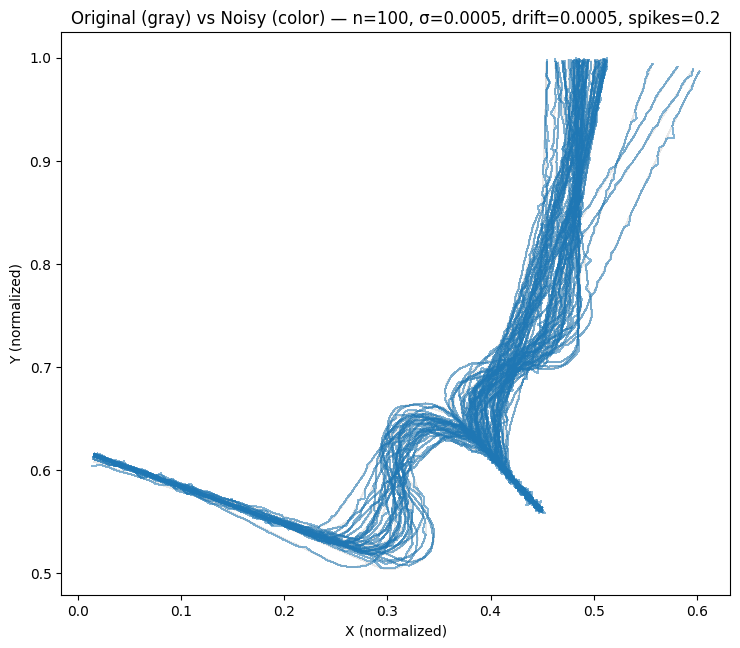

   Exported JSONL: best_100_original_plus_noisy.jsonl
Done.


In [ ]:
res = run_noisify_from_bestlist(
    resampled_csv="traffic_noga_resampled.csv",
    best_list_csv="top_best_100_reconstructed_flights.csv",
    T=100, N=100,
    noise_std=0.0005,   # try 0.002–0.01
    drift_mag=0.0005,    # constant shift, try 0.005–0.02
    spike_prob=0.2,   # 2% of points spiked
    spike_scale=4.0,   # spikes 4x larger than noise_std
    seed=42,
    export_json_file=True,
    save_plot=True
)

In [ ]:
# =========================================================
# One-cell notebook code: Noisify + Recon(Noisy) + Recon(Clean)
# - Input trajectories assumed normalized to [0,1]
# - Uses your saved "best flights" CSV to pick trajectories
# - Reconstructs from NOISY and from ORIGINAL (CLEAN)
# =========================================================

import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import torch
import torch.nn as nn
import joblib

# -------------------- Data I/O --------------------
def load_resampled_csv(path: str) -> pd.DataFrame:
    assert os.path.exists(path), f"Missing {path}"
    df = pd.read_csv(path, sep=None, engine="python")
    df.columns = (df.columns.astype(str).str.strip()
                  .str.replace(r"\s+", "_", regex=True)
                  .str.lower())
    rename = {}
    for cand in ["flight_id","flightid","fid","id_vol","id"]:
        if cand in df.columns: rename[cand] = "flight_id"; break
    for cand in ["x","lon","longitude","long"]:
        if cand in df.columns: rename[cand] = "x"; break
    for cand in ["y","lat","latitude"]:
        if cand in df.columns: rename[cand] = "y"; break
    for cand in ["timestamp","time","datetime","date_time","date","heure","ts","epoch","unix"]:
        if cand in df.columns: rename[cand] = "timestamp"; break
    if rename: df = df.rename(columns=rename)

    missing = [c for c in ["flight_id","x","y"] if c not in df.columns]
    assert not missing, f"CSV missing required columns: {missing}"

    for col in ["x","y"]:
        if not np.issubdtype(df[col].dtype, np.number):
            df[col] = (df[col].astype(str)
                           .str.replace("\u202f","", regex=False)
                           .str.replace("\xa0","", regex=False)
                           .str.replace(" ", "", regex=False)
                           .str.replace(",", ".", regex=False))
            df[col] = pd.to_numeric(df[col], errors="coerce")

    if "timestamp" not in df.columns:
        df["timestamp"] = df.groupby("flight_id", sort=False).cumcount().astype("int64")
    else:
        if np.issubdtype(df["timestamp"].dtype, np.number):
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", utc=True, errors="coerce")
        else:
            df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce", dayfirst=True)

    df = df.dropna(subset=["x","y","timestamp"]).sort_values(["flight_id","timestamp"], kind="mergesort")
    return df

def load_best_list(best_csv: str, N: int | None = None) -> np.ndarray:
    assert os.path.exists(best_csv), f"Missing {best_csv}"
    best_df = pd.read_csv(best_csv)
    assert "flight_id" in best_df.columns, "best list CSV must have 'flight_id'"
    ids = best_df["flight_id"].astype(str).to_numpy()
    return ids[:N] if N is not None else ids

def build_feature_matrix_for_ids(df: pd.DataFrame, flight_ids_wanted: np.ndarray, T: int):
    df = df[df["flight_id"].astype(str).isin(flight_ids_wanted.astype(str))].copy()
    df["rank"] = df.groupby("flight_id").cumcount()
    counts = df.groupby("flight_id")["rank"].max().add(1)
    complete_ids = counts.index[counts.eq(T)].astype(str)
    df = df[df["flight_id"].astype(str).isin(complete_ids)].copy()
    df["wanted_order"] = pd.Categorical(df["flight_id"].astype(str),
                                        categories=flight_ids_wanted.astype(str),
                                        ordered=True)
    df = df.sort_values(["wanted_order","rank"], kind="mergesort")

    x_wide = df.pivot(index="flight_id", columns="rank", values="x").reindex(flight_ids_wanted).dropna()
    y_wide = df.pivot(index="flight_id", columns="rank", values="y").reindex(flight_ids_wanted).dropna()

    kept_ids = x_wide.index.astype(str).to_numpy()
    X = np.concatenate([x_wide.to_numpy(dtype=np.float32, copy=True),
                        y_wide.to_numpy(dtype=np.float32, copy=True)], axis=1)
    return X, kept_ids

# -------------------- Noise in normalized space [0,1] --------------------
def add_noise_normalized(xy: np.ndarray, T: int,
                         noise_std: float = 0.003,
                         drift_mag: float = 0.00,
                         spike_prob: float = 0.00,
                         spike_scale: float = 4.0,
                         seed: int = 42,
                         clamp: bool = True):
    rng = np.random.default_rng(seed)
    n = xy.shape[0]
    lon = xy[:, :T].copy()
    lat = xy[:, T:].copy()

    ex = rng.normal(0.0, noise_std, size=lon.shape).astype(np.float32)
    ey = rng.normal(0.0, noise_std, size=lat.shape).astype(np.float32)

    if drift_mag != 0.0:
        d = rng.normal(0.0, 1.0, size=(n, 2)).astype(np.float32)
        d /= (np.linalg.norm(d, axis=1, keepdims=True) + 1e-9)
        ex += (d[:, 0:1] * drift_mag).repeat(T, axis=1)
        ey += (d[:, 1:2] * drift_mag).repeat(T, axis=1)

    if spike_prob > 0.0:
        spikes = rng.random(lon.shape) < spike_prob
        ex += spikes * rng.normal(0.0, spike_scale * max(noise_std, 1e-9), size=lon.shape)
        ey += spikes * rng.normal(0.0, spike_scale * max(noise_std, 1e-9), size=lat.shape)

    lon_n = lon + ex; lat_n = lat + ey
    if clamp:
        lon_n = np.clip(lon_n, 0.0, 1.0)
        lat_n = np.clip(lat_n, 0.0, 1.0)

    return np.concatenate([lon_n, lat_n], axis=1).astype(np.float32, copy=False)

# -------------------- Minimal plotting --------------------
def _overlay(lines_a, lines_b, title, filename=None):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    lc1 = LineCollection(lines_a, linewidths=0.7, colors=[(0.8,0.8,0.8,0.45)], antialiased=False)
    lc2 = LineCollection(lines_b, linewidths=0.7, antialiased=False); lc2.set_alpha(0.7)
    lc1.set_rasterized(True); lc2.set_rasterized(True)
    ax.add_collection(lc1); ax.add_collection(lc2)
    ax.autoscale(); ax.set_aspect('equal', adjustable='box'); ax.grid(False)
    ax.set_xlabel("X (normalized)"); ax.set_ylabel("Y (normalized)"); ax.set_title(title)
    fig.tight_layout(); 
    if filename: fig.savefig(filename, dpi=150)
    plt.show()

def plot_original_vs_noisy(X_best, X_noisy, T, title, filename=None):
    lines_a = [np.column_stack((X_best[i, :T],  X_best[i, T:])) for i in range(X_best.shape[0])]
    lines_b = [np.column_stack((X_noisy[i, :T], X_noisy[i, T:])) for i in range(X_noisy.shape[0])]
    _overlay(lines_a, lines_b, title, filename)

def plot_noisy_vs_recon(X_noisy, X_recon, T, title, filename=None):
    lines_a = [np.column_stack((X_noisy[i, :T],  X_noisy[i, T:])) for i in range(X_noisy.shape[0])]
    lines_b = [np.column_stack((X_recon[i, :T],   X_recon[i, T:])) for i in range(X_recon.shape[0])]
    _overlay(lines_a, lines_b, title, filename)

def plot_original_vs_recon(X_best, X_recon_clean, T, title, filename=None):
    lines_a = [np.column_stack((X_best[i, :T],        X_best[i, T:])) for i in range(X_best.shape[0])]
    lines_b = [np.column_stack((X_recon_clean[i, :T], X_recon_clean[i, T:])) for i in range(X_recon_clean.shape[0])]
    _overlay(lines_a, lines_b, title, filename)

# -------------------- Back-compat export_jsonl --------------------
def export_jsonl(path, flight_ids, *args, **arrays):
    if len(args) >= 2 and len(arrays) == 0:
        arrays = {"X_best": args[0], "X_noisy": args[1]}
    keys = list(arrays.keys())
    n = next(iter(arrays.values())).shape[0]
    for v in arrays.values():
        assert v.shape[0] == n, "All arrays must share the same first dimension"
    with open(path, "w", encoding="utf-8") as f:
        for i in range(n):
            row = {"flight_id": str(flight_ids[i])}
            for k in keys:
                row[k] = arrays[k][i].tolist()
            f.write(json.dumps(row, ensure_ascii=False) + "\n")
    return path

# -------------------- Build noisy set from best list --------------------
def run_noisify_from_bestlist(
    resampled_csv="traffic_noga_resampled.csv",
    best_list_csv="top_best_100_reconstructed_flights.csv",
    T=100, N=100,
    noise_std=0.003,
    drift_mag=0.00,
    spike_prob=0.00,
    spike_scale=4.0,
    seed=42,
    export_json_file=True,
    save_plot=True
):
    best_ids = load_best_list(best_list_csv, N)
    df = load_resampled_csv(resampled_csv)
    X_best, ids_kept = build_feature_matrix_for_ids(df, best_ids, T)
    if X_best.shape[0] == 0:
        raise RuntimeError("No matching flights with exact T samples.")

    X_noisy = add_noise_normalized(
        X_best, T,
        noise_std=noise_std, drift_mag=drift_mag,
        spike_prob=spike_prob, spike_scale=spike_scale,
        seed=seed, clamp=True
    )
    if save_plot:
        plot_original_vs_noisy(
            X_best, X_noisy, T,
            title=f"Original (gray) vs Noisy (color) — n={X_best.shape[0]}, σ={noise_std}, drift={drift_mag}, spikes={spike_prob}",
            filename="best_original_vs_noisy.png"
        )
    if export_json_file:
        export_jsonl(f"best_{X_best.shape[0]}_original_plus_noisy.jsonl", ids_kept, X_best, X_noisy, T)

    return {"X_best": X_best, "X_noisy": X_noisy, "flight_ids": ids_kept, "T": T}

# -------------------- Tiny AE + auto-detect dims --------------------
class TrajectoryAutoencoder(nn.Module):
    def __init__(self, input_dim=200, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def _shape(state, key):
    if key in state: return state[key].shape
    for k, v in state.items():
        if k.endswith(key): return v.shape
    raise KeyError(f"Key not found in checkpoint: {key}")

def load_scaler_model_auto(scaler_path: str, model_path: str, fp16: bool=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    scaler = joblib.load(scaler_path)
    state  = torch.load(model_path, map_location=device)
    in_dim = int(_shape(state, "encoder.0.weight")[1])   # [128, input_dim]
    latent = int(_shape(state, "encoder.4.weight")[0])   # [latent_dim, 64]
    T_ckpt = in_dim // 2

    model = TrajectoryAutoencoder(input_dim=in_dim, latent_dim=latent).to(device)
    model.load_state_dict(state, strict=True)
    model.eval()
    use_half = bool(fp16 and device.type == 'cuda')
    if use_half: model.half()
    return scaler, model, device, use_half, T_ckpt, in_dim, latent

@torch.no_grad()
def reconstruct_with_ae(X: np.ndarray, scaler, model, device, use_fp16=False):
    first_lin = next(m for m in model.encoder if isinstance(m, nn.Linear))
    expect = first_lin.in_features
    if X.shape[1] != expect:
        raise ValueError(f"Got X with {X.shape[1]} features, but model expects {expect}. "
                         f"Rebuild trajectories with T={expect//2}.")
    Xs = scaler.transform(X).astype(np.float32, copy=False)
    Xt = torch.from_numpy(Xs).to(device)
    if use_fp16: Xt = Xt.half()
    B = 8192 if device.type == 'cuda' else 2048
    outs = []
    for i in range(0, Xt.shape[0], B):
        outs.append(model(Xt[i:i+B]))
    Xr_scaled = torch.cat(outs, dim=0).float().cpu().numpy()
    X_recon   = scaler.inverse_transform(Xr_scaled).astype(np.float32, copy=False)
    diff = (X.astype(np.float32, copy=False) - X_recon)
    mse  = np.mean(diff * diff, axis=1).astype(np.float64, copy=False)
    return X_recon, mse

# -------------------- NEW: Reconstruct BOTH noisy & clean --------------------
def reconstruct_from_res_both(
    res: dict,
    scaler_path="trajectory_scaler.joblib",
    model_path="trajectory_autoencoder.pth",
    fp16=False,
    show_plots=True
):
    """
    Takes the result of run_noisify_from_bestlist(...) and reconstructs:
      - from noisy inputs  -> X_recon_noisy, mse_noisy
      - from original (clean) inputs -> X_recon_clean, mse_clean
    Also shows overlays if show_plots=True.
    """
    X_best  = res["X_best"]
    X_noisy = res["X_noisy"]
    ids     = res.get("flight_ids", None)

    scaler, model, device, use_half, T_ckpt, in_dim, latent = load_scaler_model_auto(scaler_path, model_path, fp16=fp16)
    if X_best.shape[1] != in_dim:
        raise ValueError(f"Your sets were built with T={X_best.shape[1]//2}, but model expects T={T_ckpt}. "
                         f"Rerun run_noisify_from_bestlist(..., T={T_ckpt}, ...).")

    # Recon from NOISY
    X_recon_noisy, mse_noisy = reconstruct_with_ae(X_noisy, scaler, model, device, use_fp16=use_half)
    # Recon from ORIGINAL (CLEAN)
    X_recon_clean, mse_clean = reconstruct_with_ae(X_best,  scaler, model, device, use_fp16=use_half)

    print(f"[AE] NOISY  recon — mean MSE: {mse_noisy.mean():.6f} | median: {np.median(mse_noisy):.6f}")
    print(f"[AE] CLEAN  recon — mean MSE: {mse_clean.mean():.6f} | median: {np.median(mse_clean):.6f} (latent={latent})")

    if show_plots:
        plot_noisy_vs_recon(
            X_noisy, X_recon_noisy, T_ckpt,
            title=f"Noisy (gray) vs AE Recon (color) — n={X_noisy.shape[0]}",
            filename="noisy_vs_reconstruction_overlay.png"
        )
        plot_original_vs_recon(
            X_best, X_recon_clean, T_ckpt,
            title=f"Original (gray) vs AE Recon (color) — n={X_best.shape[0]}",
            filename="original_vs_reconstruction_overlay.png"
        )

    return {
        "X_recon_noisy": X_recon_noisy,
        "mse_noisy": mse_noisy,
        "X_recon_clean": X_recon_clean,
        "mse_clean": mse_clean,
        "T": T_ckpt,
        "latent": latent,
        "flight_ids": ids
    }


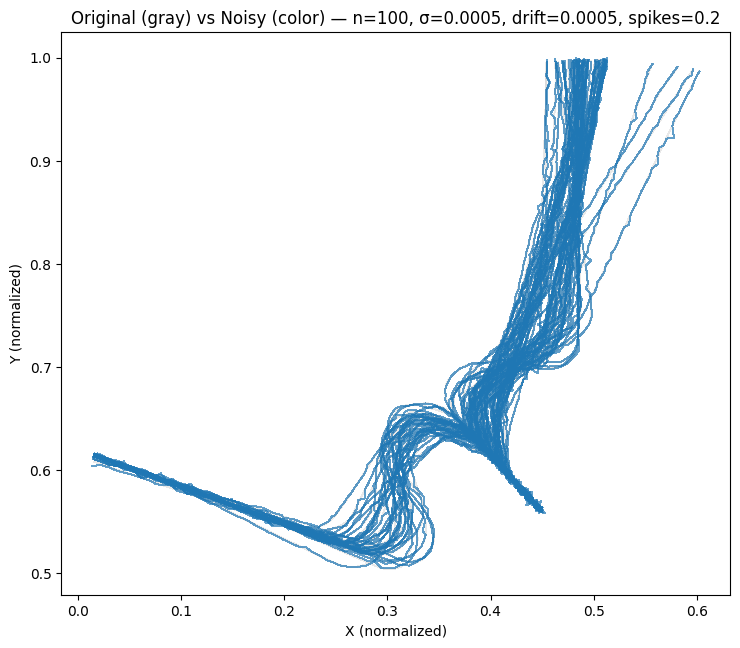

[AE] NOISY  recon — mean MSE: 0.000122 | median: 0.000031
[AE] CLEAN  recon — mean MSE: 0.000004 | median: 0.000004 (latent=16)


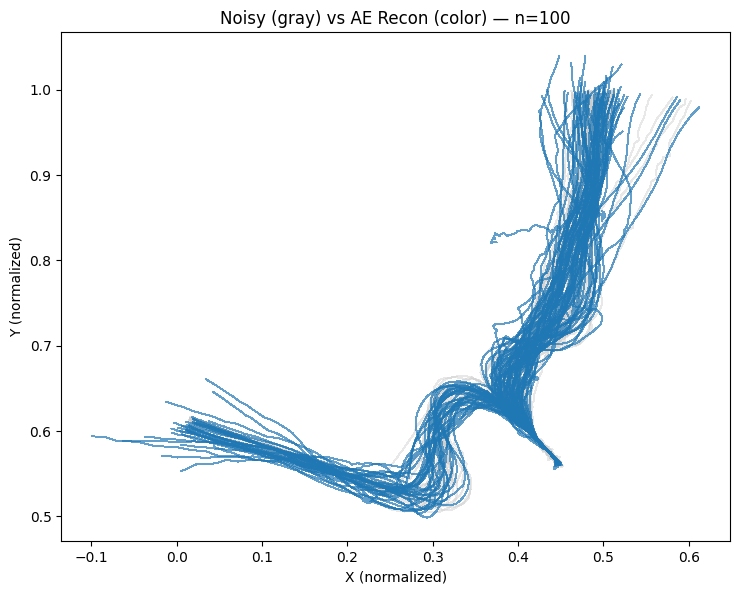

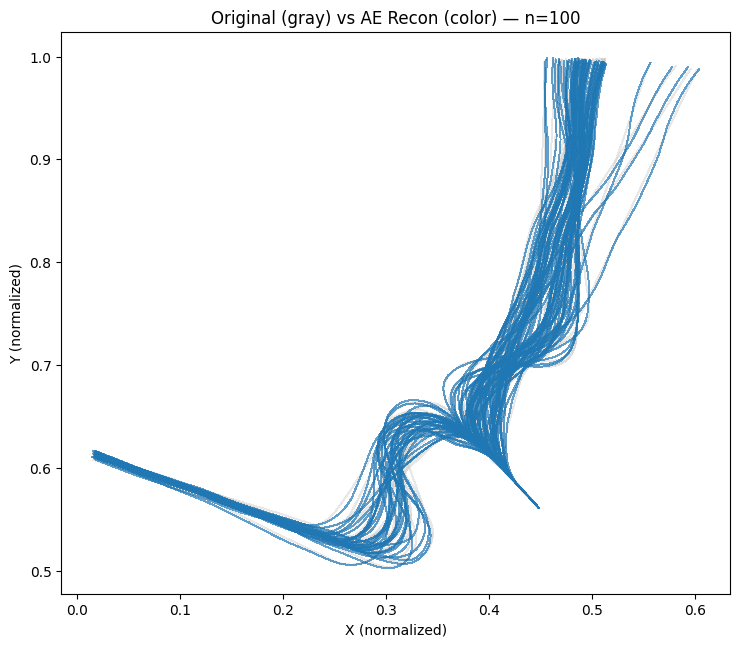

In [ ]:
# 1) Noisify best trajectories (normalized space)
res = run_noisify_from_bestlist(
    resampled_csv="traffic_noga_resampled.csv",
    best_list_csv="top_best_100_reconstructed_flights.csv",
    T=100, N=100,
    noise_std=0.0005,
    drift_mag=0.0005,
    spike_prob=0.2,     # 20% spikes
    spike_scale=4.0,
    seed=42,
    export_json_file=True,
    save_plot=True
)

# 2) Reconstruct from NOISY and from ORIGINAL (CLEAN) + plots
recons = reconstruct_from_res_both(
    res,
    scaler_path="trajectory_scaler.joblib",
    model_path="trajectory_autoencoder.pth",
    fp16=False,
    show_plots=True
)

# Access arrays if needed:
X_recon_noisy = recons["X_recon_noisy"]
X_recon_clean = recons["X_recon_clean"]
mse_noisy     = recons["mse_noisy"]
mse_clean     = recons["mse_clean"]


In [ ]:
# ============================================================
# Average impact of noise on AE reconstruction — multiple sweeps
# Makes 3 plots: vs noise_std, vs drift_mag, vs spike_prob
# Baseline = AE reconstruction of CLEAN (original) trajectories
# Error = RMSE( recon(noisy) vs recon(clean) ), averaged over flights
# Trajectories are assumed normalized to [0,1]
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import joblib

# ---------- Minimal data helpers ----------
def _load_resampled_csv(path: str) -> pd.DataFrame:
    assert os.path.exists(path), f"Missing {path}"
    df = pd.read_csv(path, sep=None, engine="python")
    df.columns = (df.columns.astype(str).str.strip()
                  .str.replace(r"\s+", "_", regex=True)
                  .str.lower())
    ren = {}
    for c in ["flight_id","flightid","fid","id_vol","id"]:
        if c in df.columns: ren[c] = "flight_id"; break
    for c in ["x","lon","longitude","long"]:
        if c in df.columns: ren[c] = "x"; break
    for c in ["y","lat","latitude"]:
        if c in df.columns: ren[c] = "y"; break
    for c in ["timestamp","time","datetime","date_time","date","heure","ts","epoch","unix"]:
        if c in df.columns: ren[c] = "timestamp"; break
    if ren: df = df.rename(columns=ren)

    # numeric cast (even if already normalized)
    for col in ["x","y"]:
        if not np.issubdtype(df[col].dtype, np.number):
            df[col] = (df[col].astype(str)
                           .str.replace("\u202f","", regex=False)
                           .str.replace("\xa0","", regex=False)
                           .str.replace(" ", "", regex=False)
                           .str.replace(",", ".", regex=False))
            df[col] = pd.to_numeric(df[col], errors="coerce")

    if "timestamp" not in df.columns:
        df["timestamp"] = df.groupby("flight_id", sort=False).cumcount().astype("int64")
    else:
        if np.issubdtype(df["timestamp"].dtype, np.number):
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", utc=True, errors="coerce")
        else:
            df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce", dayfirst=True)

    df = df.dropna(subset=["x","y","timestamp"]).sort_values(["flight_id","timestamp"], kind="mergesort")
    return df

def _load_best_ids(best_csv: str, N: int) -> np.ndarray:
    assert os.path.exists(best_csv), f"Missing {best_csv}"
    best_df = pd.read_csv(best_csv)
    assert "flight_id" in best_df.columns, "best list CSV must have 'flight_id'"
    return best_df["flight_id"].astype(str).head(N).to_numpy()

def _build_feature_matrix_for_ids(df: pd.DataFrame, wanted_ids: np.ndarray, T: int):
    df = df[df["flight_id"].astype(str).isin(wanted_ids)].copy()
    df["rank"] = df.groupby("flight_id").cumcount()
    counts = df.groupby("flight_id")["rank"].max().add(1)
    complete_ids = counts.index[counts.eq(T)].astype(str)

    df = df[df["flight_id"].astype(str).isin(complete_ids)].copy()
    df["wanted_order"] = pd.Categorical(df["flight_id"].astype(str), categories=wanted_ids, ordered=True)
    df = df.sort_values(["wanted_order","rank"], kind="mergesort")

    x_wide = df.pivot(index="flight_id", columns="rank", values="x").reindex(wanted_ids).dropna()
    y_wide = df.pivot(index="flight_id", columns="rank", values="y").reindex(wanted_ids).dropna()

    kept_ids = x_wide.index.astype(str).to_numpy()
    X = np.concatenate([x_wide.to_numpy(dtype=np.float32, copy=True),
                        y_wide.to_numpy(dtype=np.float32, copy=True)], axis=1)
    return X, kept_ids

# ---------- Noise directly in normalized space ----------
def _add_noise_normalized(xy: np.ndarray, T: int,
                          noise_std: float,
                          drift_mag: float = 0.0,
                          spike_prob: float = 0.0,
                          spike_scale: float = 4.0,
                          seed: int = 42,
                          clamp: bool = True):
    rng = np.random.default_rng(seed)
    n = xy.shape[0]
    lon = xy[:, :T].copy(); lat = xy[:, T:].copy()

    ex = rng.normal(0.0, noise_std, size=lon.shape).astype(np.float32)
    ey = rng.normal(0.0, noise_std, size=lat.shape).astype(np.float32)

    if drift_mag != 0.0:
        d = rng.normal(0.0, 1.0, size=(n, 2)).astype(np.float32)
        d /= (np.linalg.norm(d, axis=1, keepdims=True) + 1e-9)
        ex += (d[:, 0:1] * drift_mag).repeat(T, axis=1)
        ey += (d[:, 1:2] * drift_mag).repeat(T, axis=1)

    if spike_prob > 0.0:
        spikes = rng.random(lon.shape) < spike_prob
        ex += spikes * rng.normal(0.0, spike_scale * max(noise_std, 1e-9), size=lon.shape)
        ey += spikes * rng.normal(0.0, spike_scale * max(noise_std, 1e-9), size=lat.shape)

    lon_n = lon + ex; lat_n = lat + ey
    if clamp:
        lon_n = np.clip(lon_n, 0.0, 1.0); lat_n = np.clip(lat_n, 0.0, 1.0)
    return np.concatenate([lon_n, lat_n], axis=1).astype(np.float32, copy=False)

# ---------- Tiny AE + auto-detect dims ----------
class _AE(nn.Module):
    def __init__(self, input_dim=200, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x): return self.decoder(self.encoder(x))

def _shape(state, key):
    if key in state: return state[key].shape
    for k, v in state.items():
        if k.endswith(key): return v.shape
    raise KeyError(f"Key not found: {key}")

def _load_scaler_model_auto(scaler_path: str, model_path: str):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    scaler = joblib.load(scaler_path)
    state  = torch.load(model_path, map_location=device)
    in_dim = int(_shape(state, "encoder.0.weight")[1])   # [128, input_dim]
    latent = int(_shape(state, "encoder.4.weight")[0])   # [latent_dim, 64]
    T_ckpt = in_dim // 2
    model = _AE(input_dim=in_dim, latent_dim=latent).to(device)
    model.load_state_dict(state, strict=True); model.eval()
    return scaler, model, device, T_ckpt, in_dim, latent

@torch.no_grad()
def _ae_reconstruct(X: np.ndarray, scaler, model, device):
    first_lin = next(m for m in model.encoder if isinstance(m, nn.Linear))
    expect = first_lin.in_features
    assert X.shape[1] == expect, f"X has {X.shape[1]} features, model expects {expect}"
    Xs = scaler.transform(X).astype(np.float32, copy=False)
    Xt = torch.from_numpy(Xs).to(device)
    B = 8192 if device.type == 'cuda' else 2048
    outs = []
    for i in range(0, Xt.shape[0], B):
        outs.append(model(Xt[i:i+B]))
    Xr_scaled = torch.cat(outs, dim=0).float().cpu().numpy()
    return scaler.inverse_transform(Xr_scaled).astype(np.float32, copy=False)

def _avg_rmse_vs_baseline(X_recon_noisy, X_recon_clean, T):
    dx = X_recon_noisy[:, :T] - X_recon_clean[:, :T]
    dy = X_recon_noisy[:,  T:] - X_recon_clean[:,  T:]
    dist = np.sqrt(dx*dx + dy*dy)                    # (n, T)
    rmse_traj = np.sqrt((dist**2).mean(axis=1))      # (n,)
    return rmse_traj.mean(), np.median(rmse_traj), np.percentile(rmse_traj, 90)

# ---------- Main: multiple parameter sweeps ----------
def sweep_noise_impact_multi(
    resampled_csv="traffic_noga_resampled.csv",
    best_list_csv="top_best_100_reconstructed_flights.csv",
    scaler_path="trajectory_scaler.joblib",
    model_path="trajectory_autoencoder.pth",
    N=100,
    # Sweeps:
    noise_stds=(0.0, 0.0002, 0.0005, 0.001, 0.002, 0.005),
    drift_mags=(0.0, 0.0002, 0.0005, 0.001, 0.002),
    spike_probs=(0.0, 0.02, 0.05, 0.1, 0.2),
    spike_scale=4.0,
    # Baseline values for the non-swept params:
    base_noise_std=0.0005,
    base_drift_mag=0.0005,
    base_spike_prob=0.2,
    base_seed=42
):
    # 1) AE + T + data
    scaler, model, device, T_ckpt, in_dim, latent = _load_scaler_model_auto(scaler_path, model_path)
    df = _load_resampled_csv(resampled_csv)
    ids_best = _load_best_ids(best_list_csv, N)
    X_best, ids_kept = _build_feature_matrix_for_ids(df, ids_best, T_ckpt)
    n = X_best.shape[0]
    if n == 0: raise RuntimeError("No matching flights with exact T samples.")
    if n < N: print(f"[WARN] Using {n} trajectories (some missing T={T_ckpt}).")

    # 2) Baseline reconstruction from CLEAN
    X_recon_clean = _ae_reconstruct(X_best, scaler, model, device)

    results = {}

    # ---- Sweep σ (noise_std) ----
    rows = []
    for s in noise_stds:
        X_noisy = _add_noise_normalized(
            X_best, T_ckpt,
            noise_std=s,
            drift_mag=base_drift_mag,
            spike_prob=base_spike_prob,
            spike_scale=spike_scale,
            seed=base_seed, clamp=True
        )
        X_recon_noisy = _ae_reconstruct(X_noisy, scaler, model, device)
        mean_rmse, med_rmse, p90_rmse = _avg_rmse_vs_baseline(X_recon_noisy, X_recon_clean, T_ckpt)
        rows.append((s, mean_rmse, med_rmse, p90_rmse))
    results["noise_std"] = pd.DataFrame(rows, columns=["param", "rmse_mean", "rmse_median", "rmse_p90"])

    # ---- Sweep drift_mag ----
    rows = []
    for d in drift_mags:
        X_noisy = _add_noise_normalized(
            X_best, T_ckpt,
            noise_std=base_noise_std,
            drift_mag=d,
            spike_prob=base_spike_prob,
            spike_scale=spike_scale,
            seed=base_seed, clamp=True
        )
        X_recon_noisy = _ae_reconstruct(X_noisy, scaler, model, device)
        mean_rmse, med_rmse, p90_rmse = _avg_rmse_vs_baseline(X_recon_noisy, X_recon_clean, T_ckpt)
        rows.append((d, mean_rmse, med_rmse, p90_rmse))
    results["drift_mag"] = pd.DataFrame(rows, columns=["param", "rmse_mean", "rmse_median", "rmse_p90"])

    # ---- Sweep spike_prob (spike_scale fixed) ----
    rows = []
    for p in spike_probs:
        X_noisy = _add_noise_normalized(
            X_best, T_ckpt,
            noise_std=base_noise_std,
            drift_mag=base_drift_mag,
            spike_prob=p,
            spike_scale=spike_scale,
            seed=base_seed, clamp=True
        )
        X_recon_noisy = _ae_reconstruct(X_noisy, scaler, model, device)
        mean_rmse, med_rmse, p90_rmse = _avg_rmse_vs_baseline(X_recon_noisy, X_recon_clean, T_ckpt)
        rows.append((p, mean_rmse, med_rmse, p90_rmse))
    results["spike_prob"] = pd.DataFrame(rows, columns=["param", "rmse_mean", "rmse_median", "rmse_p90"])

    # 3) Plot the three sweeps
    def _plot(df, xlab, title, fname):
        fig, ax = plt.subplots(figsize=(6.5,4.0))
        ax.plot(df["param"], df["rmse_mean"],   marker="o", label="mean RMSE")
        ax.plot(df["param"], df["rmse_median"], marker="o", label="median RMSE")
        ax.plot(df["param"], df["rmse_p90"],    marker="o", label="p90 RMSE")
        ax.set_xlabel(xlab)
        ax.set_ylabel("error vs baseline recon (normalized)")
        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
        fig.tight_layout()
        plt.show()

    _plot(results["noise_std"],
          "noise_std (normalized units)",
          f"Impact of σ on AE recon (n={n}, T={T_ckpt}, latent={latent})",
          "impact_sigma.png")

    _plot(results["drift_mag"],
          "drift_mag (normalized units)",
          f"Impact of drift on AE recon (n={n}, T={T_ckpt}, latent={latent})",
          "impact_drift.png")

    _plot(results["spike_prob"],
          "spike_prob (probability per point)",
          f"Impact of spikes (scale={spike_scale}) on AE recon (n={n}, T={T_ckpt}, latent={latent})",
          "impact_spikes.png")

    meta = dict(T=T_ckpt, latent=latent, n=n, ids=ids_kept,
                base_noise_std=base_noise_std,
                base_drift_mag=base_drift_mag,
                base_spike_prob=base_spike_prob,
                spike_scale=spike_scale)
    return results, meta


In [ ]:
# ============================================================
# Robust sweeps + ONE FIGURE with 3 BOX-PLOT PANELS
#   Panel 1: noise_std sweep
#   Panel 2: drift_mag sweep
#   Panel 3: spike_prob sweep (with fixed spike_scale)
#
# RMSE definition:
#   For each trajectory and run, we compute:
#     recon_clean  = AE(X_clean)
#     recon_noisy  = AE(noise(X_clean))
#     dist_t       = sqrt((x_noisy_recon - x_clean_recon)^2 + (y_noisy_recon - y_clean_recon)^2)
#     rmse_traj    = sqrt(mean_t(dist_t^2))   # normalized units
# Box for a parameter value = distribution of rmse_traj over all trajectories and runs
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import joblib

# --------- Minimal data helpers ---------
def _load_resampled_csv(path: str) -> pd.DataFrame:
    assert os.path.exists(path), f"Missing {path}"
    df = pd.read_csv(path, sep=None, engine="python")
    df.columns = (df.columns.astype(str).str.strip()
                  .str.replace(r"\s+", "_", regex=True)
                  .str.lower())
    ren = {}
    for c in ["flight_id","flightid","fid","id_vol","id"]:
        if c in df.columns: ren[c] = "flight_id"; break
    for c in ["x","lon","longitude","long"]:
        if c in df.columns: ren[c] = "x"; break
    for c in ["y","lat","latitude"]:
        if c in df.columns: ren[c] = "y"; break
    for c in ["timestamp","time","datetime","date_time","date","heure","ts","epoch","unix"]:
        if c in df.columns: ren[c] = "timestamp"; break
    if ren: df = df.rename(columns=ren)

    for col in ["x","y"]:
        if not np.issubdtype(df[col].dtype, np.number):
            df[col] = (df[col].astype(str)
                           .str.replace("\u202f","", regex=False)
                           .str.replace("\xa0","", regex=False)
                           .str.replace(" ", "", regex=False)
                           .str.replace(",", ".", regex=False))
            df[col] = pd.to_numeric(df[col], errors="coerce")

    if "timestamp" not in df.columns:
        df["timestamp"] = df.groupby("flight_id", sort=False).cumcount().astype("int64")
    else:
        if np.issubdtype(df["timestamp"].dtype, np.number):
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", utc=True, errors="coerce")
        else:
            df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce", dayfirst=True)

    df = df.dropna(subset=["x","y","timestamp"]).sort_values(["flight_id","timestamp"], kind="mergesort")
    return df

def _load_best_ids(best_csv: str, N: int) -> np.ndarray:
    assert os.path.exists(best_csv), f"Missing {best_csv}"
    best_df = pd.read_csv(best_csv)
    assert "flight_id" in best_df.columns, "best list CSV must have 'flight_id'"
    return best_df["flight_id"].astype(str).head(N).to_numpy()

def _build_feature_matrix_for_ids(df: pd.DataFrame, wanted_ids: np.ndarray, T: int):
    df = df[df["flight_id"].astype(str).isin(wanted_ids)].copy()
    df["rank"] = df.groupby("flight_id").cumcount()
    counts = df.groupby("flight_id")["rank"].max().add(1)
    complete_ids = counts.index[counts.eq(T)].astype(str)
    df = df[df["flight_id"].astype(str).isin(complete_ids)].copy()
    df["wanted_order"] = pd.Categorical(df["flight_id"].astype(str), categories=wanted_ids, ordered=True)
    df = df.sort_values(["wanted_order","rank"], kind="mergesort")

    x_wide = df.pivot(index="flight_id", columns="rank", values="x").reindex(wanted_ids).dropna()
    y_wide = df.pivot(index="flight_id", columns="rank", values="y").reindex(wanted_ids).dropna()

    kept_ids = x_wide.index.astype(str).to_numpy()
    X = np.concatenate([x_wide.to_numpy(dtype=np.float32, copy=True),
                        y_wide.to_numpy(dtype=np.float32, copy=True)], axis=1)
    return X, kept_ids

# --------- Noise in normalized space ---------
def _add_noise_normalized(xy: np.ndarray, T: int,
                          noise_std: float,
                          drift_mag: float = 0.0,
                          spike_prob: float = 0.0,
                          spike_scale: float = 4.0,
                          seed: int = 42,
                          clamp: bool = True):
    rng = np.random.default_rng(seed)
    n = xy.shape[0]
    lon = xy[:, :T].copy()
    lat = xy[:, T:].copy()

    ex = rng.normal(0.0, noise_std, size=lon.shape).astype(np.float32)
    ey = rng.normal(0.0, noise_std, size=lat.shape).astype(np.float32)

    if drift_mag != 0.0:
        d = rng.normal(0.0, 1.0, size=(n, 2)).astype(np.float32)
        d /= (np.linalg.norm(d, axis=1, keepdims=True) + 1e-9)
        ex += (d[:, 0:1] * drift_mag).repeat(T, axis=1)
        ey += (d[:, 1:2] * drift_mag).repeat(T, axis=1)

    if spike_prob > 0.0:
        spikes = rng.random(lon.shape) < spike_prob
        ex += spikes * rng.normal(0.0, spike_scale * max(noise_std, 1e-9), size=lon.shape)
        ey += spikes * rng.normal(0.0, spike_scale * max(noise_std, 1e-9), size=lat.shape)

    lon_n = lon + ex; lat_n = lat + ey
    if clamp:
        lon_n = np.clip(lon_n, 0.0, 1.0); lat_n = np.clip(lat_n, 0.0, 1.0)
    return np.concatenate([lon_n, lat_n], axis=1).astype(np.float32, copy=False)

# --------- AE (auto-detect dims) ---------
class _AE(nn.Module):
    def __init__(self, input_dim=200, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x): return self.decoder(self.encoder(x))

def _shape(state, key):
    if key in state: return state[key].shape
    for k, v in state.items():
        if k.endswith(key): return v.shape
    raise KeyError(f"Key not found: {key}")

def _load_scaler_model_auto(scaler_path: str, model_path: str):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    scaler = joblib.load(scaler_path)
    state  = torch.load(model_path, map_location=device)
    in_dim = int(_shape(state, "encoder.0.weight")[1])
    latent = int(_shape(state, "encoder.4.weight")[0])
    T_ckpt = in_dim // 2
    model = _AE(input_dim=in_dim, latent_dim=latent).to(device)
    model.load_state_dict(state, strict=True); model.eval()
    return scaler, model, device, T_ckpt, latent

@torch.no_grad()
def _ae_reconstruct(X: np.ndarray, scaler, model, device):
    Xs = scaler.transform(X).astype(np.float32, copy=False)
    Xt = torch.from_numpy(Xs).to(device)
    B = 8192 if device.type == 'cuda' else 2048
    outs = []
    for i in range(0, Xt.shape[0], B):
        outs.append(model(Xt[i:i+B]))
    Xr_scaled = torch.cat(outs, dim=0).float().cpu().numpy()
    return scaler.inverse_transform(Xr_scaled).astype(np.float32, copy=False)

def _rmse_vs_baseline(X_recon_noisy, X_recon_clean, T):
    dx = X_recon_noisy[:, :T] - X_recon_clean[:, :T]
    dy = X_recon_noisy[:,  T:] - X_recon_clean[:,  T:]
    dist = np.sqrt(dx*dx + dy*dy)               # (n, T)
    rmse_traj = np.sqrt((dist**2).mean(axis=1)) # (n,)
    return rmse_traj

# --------- Main: robust sweeps + ONE box-plot figure ---------
def sweep_noise_impact_boxplots(
    resampled_csv="traffic_noga_resampled.csv",
    best_list_csv="top_best_100_reconstructed_flights.csv",
    scaler_path="trajectory_scaler.joblib",
    model_path="trajectory_autoencoder.pth",
    N=100,
    # Doubled ranges:
    noise_stds=np.linspace(0, 0.005, 12),
    drift_mags=np.linspace(0, 0.005, 12),
    spike_probs=np.linspace(0, 0.3, 12),
    spike_scale=4.0,
    # Baselines when not sweeping:
    base_noise_std=0.0005,
    base_drift_mag=0.0005,
    base_spike_prob=0.2,
    # Robustness:
    n_runs=10,
    base_seed=42
):
    # 1) AE + data
    scaler, model, device, T_ckpt, latent = _load_scaler_model_auto(scaler_path, model_path)
    df = _load_resampled_csv(resampled_csv)
    ids_best = _load_best_ids(best_list_csv, N)
    X_best, ids_kept = _build_feature_matrix_for_ids(df, ids_best, T_ckpt)
    n = X_best.shape[0]
    if n == 0:
        raise RuntimeError(f"No matching flights with T={T_ckpt}.")
    if n < N:
        print(f"[WARN] Using {n}/{N} trajectories with exact T={T_ckpt}.")

    # 2) Baseline recon (CLEAN)
    X_recon_clean = _ae_reconstruct(X_best, scaler, model, device)

    # 3) Collect distributions for boxplots
    dist_noise = []  # list of arrays; one array per parameter value, length = n * n_runs
    for s in noise_stds:
        samples = []
        for r in range(n_runs):
            seed = base_seed + r
            X_noisy = _add_noise_normalized(X_best, T_ckpt,
                                            noise_std=s,
                                            drift_mag=base_drift_mag,
                                            spike_prob=base_spike_prob,
                                            spike_scale=spike_scale,
                                            seed=seed, clamp=True)
            X_recon_noisy = _ae_reconstruct(X_noisy, scaler, model, device)
            rmse = _rmse_vs_baseline(X_recon_noisy, X_recon_clean, T_ckpt)
            samples.append(rmse)
        dist_noise.append(np.concatenate(samples))

    dist_drift = []
    for d in drift_mags:
        samples = []
        for r in range(n_runs):
            seed = base_seed + r
            X_noisy = _add_noise_normalized(X_best, T_ckpt,
                                            noise_std=base_noise_std,
                                            drift_mag=d,
                                            spike_prob=base_spike_prob,
                                            spike_scale=spike_scale,
                                            seed=seed, clamp=True)
            X_recon_noisy = _ae_reconstruct(X_noisy, scaler, model, device)
            rmse = _rmse_vs_baseline(X_recon_noisy, X_recon_clean, T_ckpt)
            samples.append(rmse)
        dist_drift.append(np.concatenate(samples))

    dist_spike = []
    for p in spike_probs:
        samples = []
        for r in range(n_runs):
            seed = base_seed + r
            X_noisy = _add_noise_normalized(X_best, T_ckpt,
                                            noise_std=base_noise_std,
                                            drift_mag=base_drift_mag,
                                            spike_prob=p,
                                            spike_scale=spike_scale,
                                            seed=seed, clamp=True)
            X_recon_noisy = _ae_reconstruct(X_noisy, scaler, model, device)
            rmse = _rmse_vs_baseline(X_recon_noisy, X_recon_clean, T_ckpt)
            samples.append(rmse)
        dist_spike.append(np.concatenate(samples))

    # 4) Plot ONE figure with three box-plot panels
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle(f"Impact of noise on AE reconstruction (baseline = recon(clean))\n"
                 f"N={n} trajectories, runs={n_runs}, T={T_ckpt}, latent={latent}")

    # Panel 1: σ
    axes[0].boxplot(dist_noise, showfliers=False)
    axes[0].set_xticks(range(1, len(noise_stds)+1))
    axes[0].set_xticklabels([f"{v:.4f}" for v in noise_stds], rotation=60, ha="right")
    axes[0].set_xlabel("noise_std")
    axes[0].set_ylabel("RMSE vs baseline recon (normalized)")
    axes[0].set_title("σ sweep")

    # Panel 2: drift
    axes[1].boxplot(dist_drift, showfliers=False)
    axes[1].set_xticks(range(1, len(drift_mags)+1))
    axes[1].set_xticklabels([f"{v:.4f}" for v in drift_mags], rotation=60, ha="right")
    axes[1].set_xlabel("drift_mag")
    axes[1].set_title("drift sweep")

    # Panel 3: spikes
    axes[2].boxplot(dist_spike, showfliers=False)
    axes[2].set_xticks(range(1, len(spike_probs)+1))
    axes[2].set_xticklabels([f"{v:.2f}" for v in spike_probs], rotation=60, ha="right")
    axes[2].set_xlabel("spike_prob")
    axes[2].set_title(f"spike sweep (scale={spike_scale})")

    for ax in axes:
        ax.grid(True, axis="y", alpha=0.3)

    fig.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()

    # Optional: return the raw distributions & meta for further analysis
    return {
        "noise_std": {"params": noise_stds, "samples": dist_noise},
        "drift_mag": {"params": drift_mags, "samples": dist_drift},
        "spike_prob": {"params": spike_probs, "samples": dist_spike},
        "meta": {"N": n, "runs": n_runs, "T": T_ckpt, "latent": latent, "ids": ids_kept}
    }


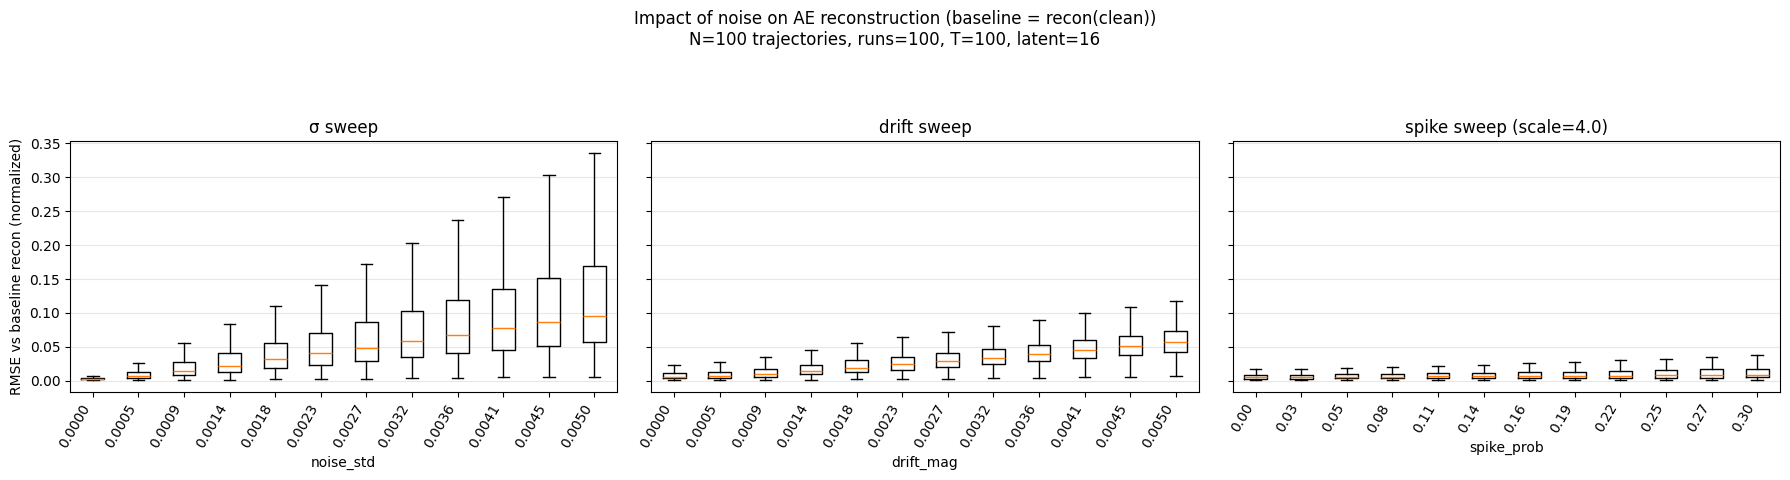

In [ ]:
box_data = sweep_noise_impact_boxplots(
    resampled_csv="traffic_noga_resampled.csv",
    best_list_csv="top_best_100_reconstructed_flights.csv",
    scaler_path="trajectory_scaler.joblib",
    model_path="trajectory_autoencoder.pth",
    N=100,
    # Doubled grids + 10 runs
    noise_stds=np.linspace(0, 0.005, 12),
    drift_mags=np.linspace(0, 0.005, 12),
    spike_probs=np.linspace(0, 0.3, 12),
    spike_scale=4.0,
    base_noise_std=0.0005,
    base_drift_mag=0.0005,
    base_spike_prob=0.2,
    n_runs=100,
    base_seed=42
)
